 ## Here are the tests for the different detectors

In [7]:
%matplotlib inline

# Import necessary dependencies
import cv2
import numpy as np
import unittest
import sys
import os
import matplotlib.pyplot as plt

print(os.getcwd())

# Import the necessary classes
from detectors import RedCapDetector 
from detectors import YOLOv5Detector
from detectors import find_intersecting_human

from segmentors import DeepLabSegmentor
from segmentors import MaskRCNNSegmentor
# from segmentors/Yolact_Segmentor import YOLACTSegmentor

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

/Users/mathiasperez/Documents/GitHub/INF573-MakeBenardDisappear


In [8]:
def imshow(image, cmap=None):
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb, cmap)
  plt.axis('off')  # Hide axis for better visualization
  plt.show()

In [9]:
"""
Set up test resources, such as the detectors and a sample image frame.
"""

# Initialize the detectors
red_cap_detector = RedCapDetector()
human_detector = YOLOv5Detector()
        
# Load a sample image for testing (replace with an appropriate test image path)
test_image = cv2.imread('_test_data/test1.jpg')  # Ensure you have a test image available
# cv2.imread loads images in BGR format by default.

imshow(test_image)

ImportError: cannot import name 'TryExcept' from 'utils' (/Users/mathiasperez/Documents/GitHub/INF573-MakeBenardDisappear/yolact/utils/__init__.py)

Red Cap Detector Output: [(424, 451, 83, 49)]


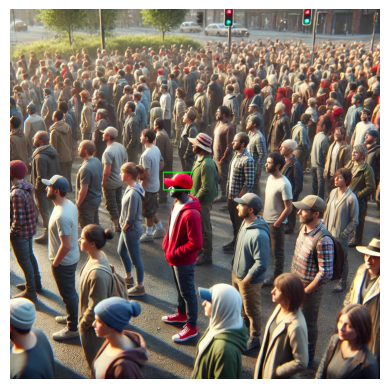

In [21]:
"""
Test if the red cap detector correctly identifies a bounding box for a red cap.
"""

red_cap_boxes = red_cap_detector.detect(test_image, hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)
print("Red Cap Detector Output:", red_cap_boxes)
# Draw the bounding box on the image knowing that the red_cap_detector returns a bounding box in the form (x, y, w, h) where the red cap is located. If no cap is found, returns None.

if red_cap_boxes is not None:
    test_image_bis = test_image.copy()
    for box in red_cap_boxes:
        x, y, w, h = box
        cv2.rectangle(test_image_bis, (x, y), (x+w, y+h), (0, 255, 0), 2)
        # cv2.putText(test_image_bis, 'Red Cap', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    imshow(test_image_bis)

indices [ 0  1  2  3  4  5  6  7  8  9 10 11]
Human Detector Output: [[0, 797, 124, 226], [671, 726, 158, 298], [415, 456, 122, 464], [500, 759, 162, 265], [849, 813, 172, 211], [606, 515, 119, 433], [774, 521, 153, 474], [219, 794, 166, 227], [96, 459, 98, 446], [291, 429, 88, 363], [179, 593, 136, 416], [0, 424, 142, 428]]


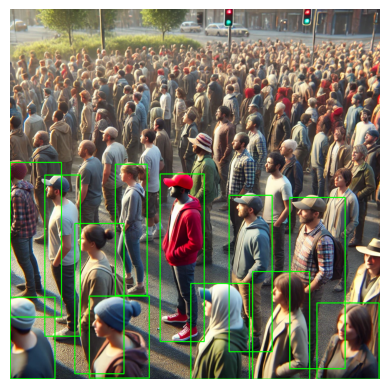

In [23]:
"""
Test if the human detector correctly identifies a bounding box for a person.
"""

human_boxes = human_detector.detect(test_image )
print("Human Detector Output:", human_boxes)
# Draw the bounding box on the image knowing that the red_cap_detector returns a bounding box in the form (x, y, w, h) where the red cap is located. If no cap is found, returns None.

if human_boxes is not None:
    test_image_bis = test_image.copy()
    for box in human_boxes:
        x, y, w, h = box
        cv2.rectangle(test_image_bis, (x, y), (x+w, y+h), (0, 255, 0), 2)
        # cv2.putText(test_image_bis, 'Human', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    imshow(test_image_bis)


Intersections: [[415, 456, 122, 464]]


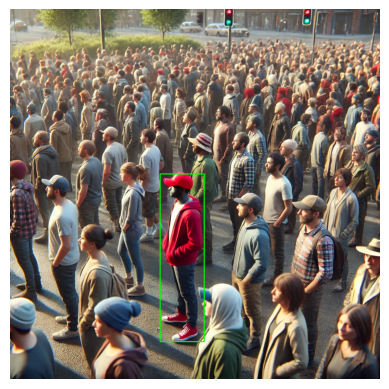

In [24]:
"""
Test if the combined detector gives good results
"""

intersections = []
for cap in red_cap_boxes:
    for human in human_boxes:
        cap_x, cap_y, cap_w, cap_h = cap
        human_x, human_y, human_w, human_h = human
        if cap_x < human_x + human_w and cap_x + cap_w > human_x and cap_y < human_y + human_h and cap_y + cap_h > human_y:
            intersections.append(human)

print("Intersections:", intersections)
# Draw the bounding box on the image knowing that the red_cap_detector returns a bounding box in the form (x, y, w, h) where the red cap is located. If no cap is found, returns None.

if intersections is not None:
    test_image_bis = test_image.copy()
    for box in intersections:
        x, y, w, h = box
        cv2.rectangle(test_image_bis, (x, y), (x+w, y+h), (0, 255, 0), 2)
        # cv2.putText(test_image_bis, 'Human', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    imshow(test_image_bis)

(1024, 1024, 3)
[[415, 456, 122, 464]]


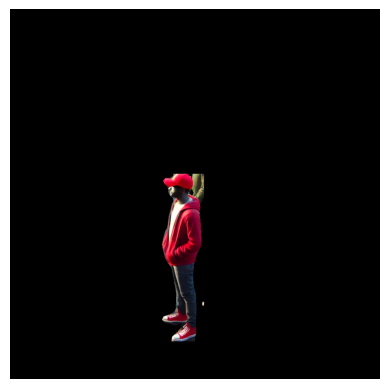

In [11]:
# Let's test the DeepLabSegmentor
segmentor = DeepLabSegmentor()
print(test_image.shape)
print(intersections)
segmented_image = segmentor.segment(test_image, intersections)

# Display the segmented image on the real image by overlaying the segmented image on the real image
test_image_bis = test_image.copy()
test_image_bis[segmented_image == 0] = 0
imshow(test_image_bis)


## Let's have more testing for the red cap detector by playing with the multiple parameters it has

In [12]:
test_image1 = cv2.imread('_test_data/test1.jpg') 
test_image2 = cv2.imread('_test_data/test2.jpg')
test_image3 = cv2.imread('_test_data/test3.jpg')
test_image4 = cv2.imread('_test_data/test4.jpg')

In [13]:
@interact(min_size = (0, 1000, 10), min_circularity = (0, 1, 0.1))
def imshow_with_red_cap(min_size, min_circularity):
    red_cap_boxes_1 = red_cap_detector.detect(test_image1,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=min_size, min_circularity=min_circularity)
    red_cap_boxes_2 = red_cap_detector.detect(test_image2,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=min_size, min_circularity=min_circularity)
    red_cap_boxes_3 = red_cap_detector.detect(test_image3, hue_range=(0, 5), alt_hue_range=(170, 180),min_size=min_size, min_circularity=min_circularity)
    red_cap_boxes_4 = red_cap_detector.detect(test_image4,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=min_size, min_circularity=min_circularity)

    if red_cap_boxes_1 is not None:
        test_image_bis1 = test_image1.copy()
        for box in red_cap_boxes_1:
            x, y, w, h = box
            cv2.rectangle(test_image_bis1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    if red_cap_boxes_2 is not None:
        test_image_bis2 = test_image2.copy()
        for box in red_cap_boxes_2:
            x, y, w, h = box
            cv2.rectangle(test_image_bis2, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    if red_cap_boxes_3 is not None:
        test_image_bis3 = test_image3.copy()
        for box in red_cap_boxes_3:
            x, y, w, h = box
            cv2.rectangle(test_image_bis3, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    if red_cap_boxes_4 is not None:
        test_image_bis4 = test_image4.copy()
        for box in red_cap_boxes_4:
            x, y, w, h = box
            cv2.rectangle(test_image_bis4, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # Display the images in a single plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Test Image 1')

    axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Test Image 2')

    axs[1, 0].imshow(cv2.cvtColor(test_image_bis3, cv2.COLOR_BGR2RGB))
    axs[1, 0].axis('off')
    axs[1, 0].set_title('Test Image 3')

    axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
    axs[1, 1].axis('off')
    axs[1, 1].set_title('Test Image 4')

    plt.show()

# Results :
# Circularity needs to be at max 0.3
# Min size at 620 detects the caps only

interactive(children=(IntSlider(value=500, description='min_size', max=1000, step=10), FloatSlider(value=0.0, …

## Lets do the same thing for the human detector now

In [14]:
@interact(conf = (0, 1, 0.1), iou = (0, 1, 0.1))
def imshow_with_yolo(conf, iou):
    human_boxes_1 = human_detector.detect(test_image1, conf, iou)
    human_boxes_2 = human_detector.detect(test_image2, conf, iou)
    human_boxes_3 = human_detector.detect(test_image3, conf, iou)
    human_boxes_4 = human_detector.detect(test_image4, conf, iou)


    if human_boxes_1 is not None:
        test_image_bis1 = test_image1.copy()
        for box in human_boxes_1:
            x, y, w, h = box
            cv2.rectangle(test_image_bis1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    if human_boxes_2 is not None:
        test_image_bis2 = test_image2.copy()
        for box in human_boxes_2:
            x, y, w, h = box
            cv2.rectangle(test_image_bis2, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if human_boxes_3 is not None:
        test_image_bis3 = test_image3.copy()
        for box in human_boxes_3:
            x, y, w, h = box
            cv2.rectangle(test_image_bis3, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if human_boxes_4 is not None:
        test_image_bis4 = test_image4.copy()
        for box in human_boxes_4:
            x, y, w, h = box
            cv2.rectangle(test_image_bis4, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # Display the images in a single plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Test Image 1')

    axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Test Image 2')

    axs[1, 0].imshow(cv2.cvtColor(test_image_bis3, cv2.COLOR_BGR2RGB))
    axs[1, 0].axis('off')
    axs[1, 0].set_title('Test Image 3')

    axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
    axs[1, 1].axis('off')
    axs[1, 1].set_title('Test Image 4')

    plt.show()

# Results :
# Conf needs to be at 0.5
# IOU needs to be at 0.5

interactive(children=(FloatSlider(value=0.0, description='conf', max=1.0), FloatSlider(value=0.0, description=…

interactive(children=(FloatSlider(value=0.0, description='conf', max=1.0), FloatSlider(value=0.0, description=…

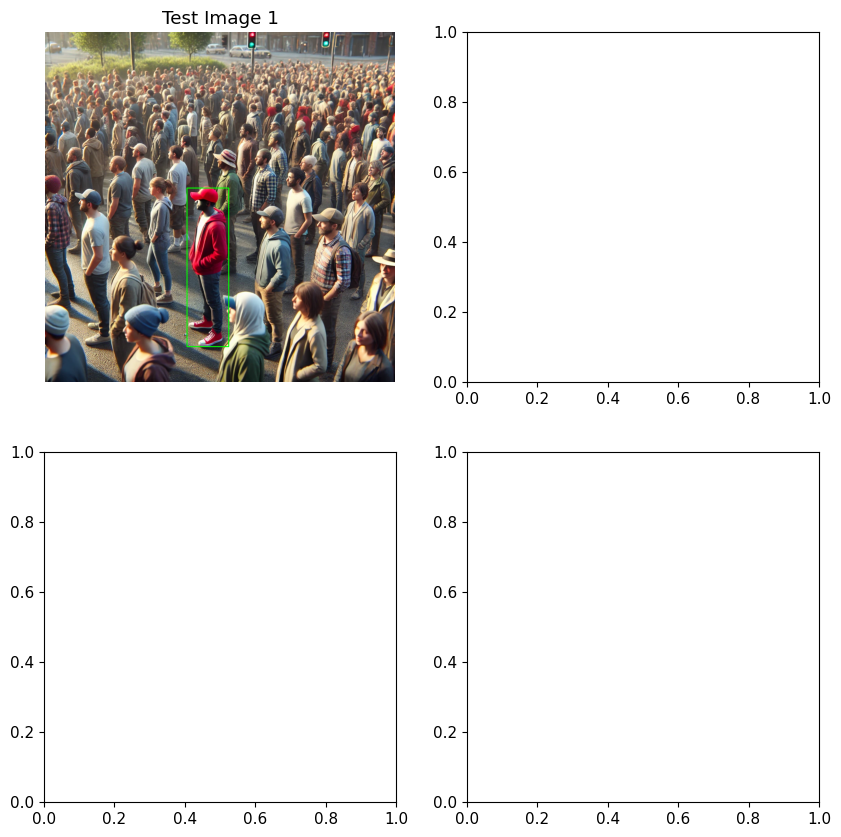

In [17]:
@interact(conf = (0, 1, 0.1), iou = (0, 1, 0.1))
def imshow_with_yolo(conf, iou):
    red_cap_boxes_1 = red_cap_detector.detect(test_image1,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)
    red_cap_boxes_2 = red_cap_detector.detect(test_image2,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)
    red_cap_boxes_3 = red_cap_detector.detect(test_image3, hue_range=(0, 5), alt_hue_range=(170, 180),min_size=620, min_circularity=0.3)
    red_cap_boxes_4 = red_cap_detector.detect(test_image4,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)

    
    human_boxes_1 = human_detector.detect(test_image1, conf, iou)
    human_boxes_2 = human_detector.detect(test_image2, conf, iou)
    human_boxes_3 = human_detector.detect(test_image3, conf, iou)
    human_boxes_4 = human_detector.detect(test_image4, conf, iou)

    intersections_1 = find_intersecting_human(red_cap_boxes_1, human_boxes_1)
    intersections_2 = find_intersecting_human(red_cap_boxes_2, human_boxes_2)
    intersections_3 = find_intersecting_human(red_cap_boxes_3, human_boxes_3)
    intersections_4 = find_intersecting_human(red_cap_boxes_4, human_boxes_4)


    if intersections_1 is not None:
        test_image_bis1 = test_image1.copy()
        for box in intersections_1:
            x, y, w, h = box
            cv2.rectangle(test_image_bis1, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if intersections_2 is not None:
        test_image_bis2 = test_image2.copy()
        for box in intersections_2:
            x, y, w, h = box
            cv2.rectangle(test_image_bis2, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if intersections_3 is not None:
        test_image_bis3 = test_image3.copy()
        for box in intersections_3:
            x, y, w, h = box
            cv2.rectangle(test_image_bis3, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if intersections_4 is not None:
        test_image_bis4 = test_image4.copy()
        for box in intersections_4:
            x, y, w, h = box
            cv2.rectangle(test_image_bis4, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # Display the images in a single plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Test Image 1')

    axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Test Image 2')

    axs[1, 0].imshow(cv2.cvtColor(test_image_bis3, cv2.COLOR_BGR2RGB))
    axs[1, 0].axis('off')
    axs[1, 0].set_title('Test Image 3')

    axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
    axs[1, 1].axis('off')
    axs[1, 1].set_title('Test Image 4')

    plt.show()

# Results :
# Conf needs to be at 0.7
# IOU needs to be more than 0.3 but more detailed testing is needed

In [18]:
def getSegmented(image):
    red_cap_boxes = red_cap_detector.detect(image,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)
    human_boxes = human_detector.detect(image, 0.7, 0.5)
    intersections = find_intersecting_human(red_cap_boxes, human_boxes)
    segmented_image = segmentor.segment(image, intersections)
    return segmented_image

indices [ 0  1  2  3  4  5  6  7  8  9 10 11]
indices [0 1 2 3 4 5 6]
indices [0 1 2 3 4 5 6 7 8]
indices [0 1 2 3 4]


Text(0.5, 1.0, 'Test Image 4')

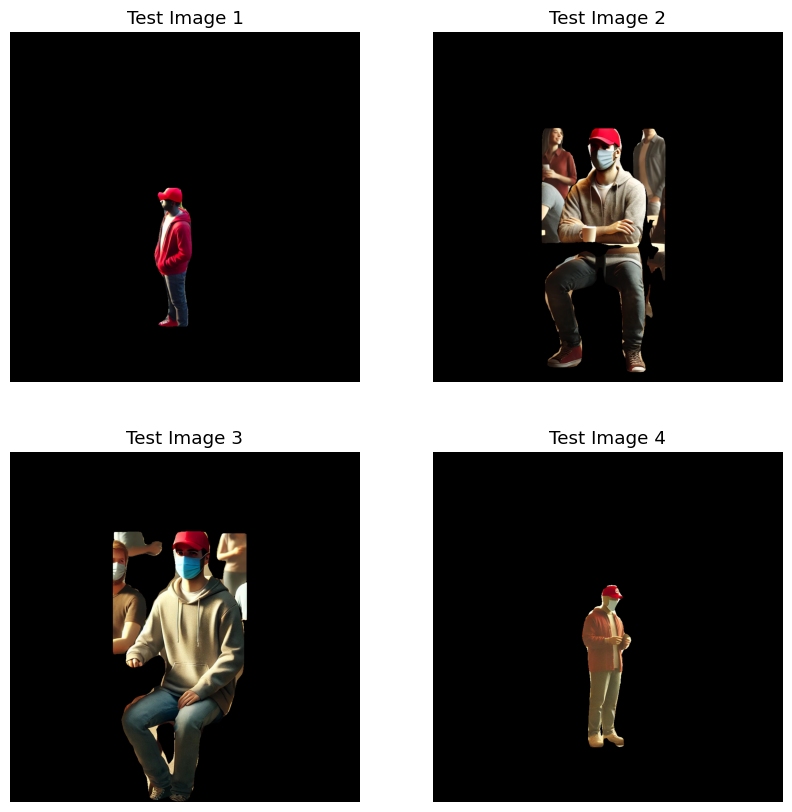

In [16]:
segmentor = MaskRCNNSegmentor()

red_cap_boxes_1 = red_cap_detector.detect(test_image1,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)
red_cap_boxes_2 = red_cap_detector.detect(test_image2,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)
red_cap_boxes_3 = red_cap_detector.detect(test_image3, hue_range=(0, 5), alt_hue_range=(170, 180),min_size=620, min_circularity=0.3)
red_cap_boxes_4 = red_cap_detector.detect(test_image4,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)

    
human_boxes_1 = human_detector.detect(test_image1)
human_boxes_2 = human_detector.detect(test_image2)
human_boxes_3 = human_detector.detect(test_image3)
human_boxes_4 = human_detector.detect(test_image4)

intersections_1 = find_intersecting_human(red_cap_boxes_1, human_boxes_1)
intersections_2 = find_intersecting_human(red_cap_boxes_2, human_boxes_2)
intersections_3 = find_intersecting_human(red_cap_boxes_3, human_boxes_3)
intersections_4 = find_intersecting_human(red_cap_boxes_4, human_boxes_4)

segmented_image1 = segmentor.segment(test_image1, intersections_1)
segmented_image2 = segmentor.segment(test_image2, intersections_2)
segmented_image3 = segmentor.segment(test_image3, intersections_3)
segmented_image4 = segmentor.segment(test_image4, intersections_4)


test_image_bis1 = test_image1.copy()
test_image_bis1[segmented_image1 == 0] = 0

test_image_bis2 = test_image2.copy()
test_image_bis2[segmented_image2 == 0] = 0

test_image_bis3 = test_image3.copy()
test_image_bis3[segmented_image3 == 0] = 0

test_image_bis4 = test_image4.copy()
test_image_bis4[segmented_image4 == 0] = 0

# Display the images in a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
axs[0, 0].axis('off')
axs[0, 0].set_title('Test Image 1')

axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
axs[0, 1].axis('off')
axs[0, 1].set_title('Test Image 2')

axs[1, 0].imshow(cv2.cvtColor(test_image_bis3, cv2.COLOR_BGR2RGB))
axs[1, 0].axis('off')
axs[1, 0].set_title('Test Image 3')

axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
axs[1, 1].axis('off')
axs[1, 1].set_title('Test Image 4')